In [17]:
source("https://bioconductor.org/biocLite.R")
biocLite("org.Hs.eg.db")

Bioconductor version 3.4 (BiocInstaller 1.24.0), ?biocLite for help
BioC_mirror: https://bioconductor.org
Using Bioconductor 3.4 (BiocInstaller 1.24.0), R 3.3.2 (2016-10-31).
Installing package(s) ‘org.Hs.eg.db’
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'backports', 'broom', 'colorspace', 'data.table', 'DBI',
  'digest', 'forcats', 'ggplot2', 'jsonlite', 'Matrix', 'mgcv', 'nlme',
  'openssl', 'pbdZMQ', 'pbkrtest', 'psych', 'Rcpp', 'RcppEigen', 'rprojroot',
  'selectr', 'shiny', 'SparseM', 'stringr', 'tidyr', 'tidyverse', 'xml2', 'zoo'


In [1]:
#libraries
library(GO.db)
library(topGO)
library(org.Hs.eg.db)
library(org.Sc.sgd.db)
library(GOSemSim)

Loading required package: AnnotationDbi
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Loading required package: Biobase
Welcome to Bioconductor

 

In [8]:
# db <- org.Sc.sgd.db
# mapping <- "org.Sc.sgd.db"
# ID <- "ENSEMBL"
db <- org.Hs.eg.db
mapping <- "org.Hs.eg.db"
ID <- "ENTREZ"

In [2]:
#background gene list
setwd('/home/david/Documents/ghsom')
# allGenes <- scan("Y2H_union.txt", character())
allGenes <- scan("HI-II-14.txt", character())
allGenes <- unique(allGenes) 

In [3]:
length(allGenes)

[1] 4303

In [4]:
##load all community gene lists
# setwd("/home/david/Documents/ghsom/union_communities_08")
setwd("/home/david/Documents/ghsom/hi_communities_08")

g <- list()
numCom <- 0
filename <- sprintf("community_%s.txt", numCom)
while (file.exists(filename)) {
    numCom <- numCom + 1
    g[[numCom]] <- scan(filename, character())
    filename <- sprintf("community_%s.txt", numCom)
}
numCom

[1] 27

In [5]:
#distances between neurons
shortest.path <- read.csv("shortest_path.csv", sep=",", header=FALSE)

In [6]:
find_representative_term <- function(terms){
    
    counts <- numeric(length(terms))
    names(counts) <- terms

    for (term in terms) {
        ancestors <- as.list(GOBPANCESTOR[term])
        for (ancestor in ancestors[[term]]) {
            if (ancestor %in% names(counts)) {
                counts[ancestor] <- counts[ancestor] + 1
            }
        }

    }
#     return (sort(names(counts), decreasing=TRUE)[1])
    return (sort(counts, decreasing=TRUE))
}

In [9]:
cutOff <- 0.05

geneLists <- vector("list", numCom) 
GOdataObjects <- vector("list", numCom) 
resultFishers <- vector("list", numCom) 
resultFisher.elims <- vector("list", numCom) 
results <- vector("list", numCom) 
topResults <- vector("list", numCom) 
gos <- vector("list", numCom) 
representativeTerms <- character(length = numCom)

#perform enrichment analyses
for (c in 1:numCom){
    
    #factor of interesting genes
    geneList <- factor(as.integer(allGenes %in% g[[c]]))
    names(geneList) <- allGenes
    geneLists[[c]] <- geneList
    
    #construct topGO object
    #yeast
#     GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
#                   ontology = "BP", allGenes = geneList,
#                   annotationFun = annFUN.org, mapping = "org.Sc.sgd.db", 
#                   ID = "ENSEMBL", nodeSize = 10)
    ##human
    GOdata <- new("topGOdata", description=sprintf("topGO object for community %s", c),
                  ontology = "BP", allGenes = geneList,
                  annotationFun = annFUN.org, mapping = mapping, 
                  ID = ID, nodeSize = 10)
    GOdataObjects[[c]] <- GOdata
    
    #fishers exact test classic
    resultFisher <- runTest(GOdata, algorithm = "classic", statistic = "fisher")
    resultFishers[[c]] <- resultFisher
    
    #fishers exact test elimination
    resultFisher.elim <- runTest(GOdata, algorithm = "elim", statistic = "fisher")
    resultFisher.elims[[c]] <- resultFisher.elim
    
    #tabulate results
    allRes <- GenTable(GOdata, classicFisher = resultFisher,
                  elimFisher = resultFisher.elim,
                  orderBy = "classicFisher", topNodes = 500)
    results[[c]] <- allRes
    
    #go terms <0.01 on both tests
    topResults[[c]] <- subset(allRes, classicFisher < cutOff & elimFisher < cutOff)
    gos[[c]] <- subset(allRes, classicFisher < cutOff & elimFisher < cutOff)$GO.ID
    
    #term that is ancestor of most terms
    representativeTerms[c] <- names(find_representative_term(gos[[c]])[1])
#     representativeTerms[c] <- gos[[c]][1]
    
    print(sprintf("community %s complete", c))
}


Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1109 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1109 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 14:	2 nodes to be scored	(0 eliminated genes)

	 Level 13:	16 nodes to be scored	(0 eliminated genes)

	 Level 12:	29 nodes to be scored	(0 eliminated genes)

	 Level 11:	39 nodes to be scored	(0 eliminated genes)

	 Level 10:	67 nodes to be scored	(0 eliminated genes)

	 Level 9:	100 nodes to be scored	(0 eliminated genes)

	 Level 8:	134 nodes to be scored	(30 eliminated genes)

	 Level 7:	175 nodes to be scored	(354 eliminated genes)

	 Level 6:	194 nodes to be scored	(354 eliminated genes)

	 Level 5:	180 no

[1] "community 1 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1580 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1580 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	4 nodes to be scored	(0 eliminated genes)

	 Level 14:	7 nodes to be scored	(0 eliminated genes)

	 Level 13:	18 nodes to be scored	(0 eliminated genes)

	 Level 12:	32 nodes to be scored	(0 eliminated genes)

	 Level 11:	68 nodes to be scored	(320 eliminated genes)

	 Level 10:	117 nodes to be scored	(977 eliminated genes)

	 Level 9:	158 nodes to be scored	(980 eliminated genes)

	 Level 8:	188 nodes to be scored	(980 eliminated genes)

	 Level 7:	252 nodes to be scored	(980 eliminated genes)

	 Level 6:	2

[1] "community 2 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2568 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2568 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	7 nodes to be scored	(0 eliminated genes)

	 Level 14:	22 nodes to be scored	(0 eliminated genes)

	 Level 13:	58 nodes to be scored	(0 eliminated genes)

	 Level 12:	99 nodes to be scored	(0 eliminated genes)

	 Level 11:	139 nodes to be scored	(21 eliminated genes)

	 Level 10:	209 nodes to be scored	(21 eliminated genes)

	 Level 9:	303 nodes 

[1] "community 3 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2256 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2256 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	6 nodes to be scored	(0 eliminated genes)

	 Level 14:	19 nodes to be scored	(0 eliminated genes)

	 Level 13:	53 nodes to be scored	(0 eliminated genes)

	 Level 12:	83 nodes to be scored	(0 eliminated genes)

	 Level 11:	113 nodes to be scored	(70 eliminated genes)

	 Level 10:	175 nodes to be scored	(78 eliminated genes)

	 Level 9:	270 nodes to be scored	(99 eliminated genes)

	 Level 8:	297 node

[1] "community 4 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1703 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1703 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	5 nodes to be scored	(0 eliminated genes)

	 Level 14:	15 nodes to be scored	(0 eliminated genes)

	 Level 13:	31 nodes to be scored	(0 eliminated genes)

	 Level 12:	56 nodes to be scored	(0 eliminated genes)

	 Level 11:	82 nodes to be scored	(0 eliminated genes)

	 Level 10:	127 nodes to be scored	(84 eliminated genes)

	 Level 9:	181 nodes to

[1] "community 5 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 815 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 815 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 13:	5 nodes to be scored	(0 eliminated genes)

	 Level 12:	16 nodes to be scored	(0 eliminated genes)

	 Level 11:	36 nodes to be scored	(0 eliminated genes)

	 Level 10:	62 nodes to be scored	(37 eliminated genes)

	 Level 9:	74 nodes to be scored	(37 eliminated genes)

	 Level 8:	86 nodes to be scored	(37 eliminated genes)

	 Level 7:	118 nodes to be scored	(37 eliminated genes)

	 Level 6:	145 nodes to be scored	(51 eliminated genes)

	 Level 5:	129 nodes to be scored	(349 eliminated genes)

	 Level 4:	91 nodes

[1] "community 6 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 987 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 987 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	2 nodes to be scored	(0 eliminated genes)

	 Level 14:	9 nodes to be scored	(0 eliminated genes)

	 Level 13:	19 nodes to be scored	(0 eliminated genes)

	 Level 12:	36 nodes to be scored	(0 eliminated genes)

	 Level 11:	49 nodes to be scored	(38 eliminated genes)

	 Level 10:	63 nodes to be scored	(241 eliminated genes)

	 Level 9:	95 nodes to be scored	(241 eliminated genes)

	 Level 8:	103 nodes to be scored	(283 eliminated genes)

	 Level 7:	144 nodes to be scored	(290 eliminated genes)

	 Level 6:	154 no

[1] "community 7 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1004 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1004 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	1 nodes to be scored	(0 eliminated genes)

	 Level 14:	10 nodes to be scored	(0 eliminated genes)

	 Level 13:	18 nodes to be scored	(84 eliminated genes)

	 Level 12:	33 nodes to be scored	(116 eliminated genes)

	 Level 11:	41 nodes to be scored	(153 eliminated genes)

	 Level 10:	53 nodes to be scored	(153 eliminated genes)

	 Level 9:	106 nodes to be scored	(163 eliminated genes)

	 Level 8:	125 nodes to be scored	(211 eliminated genes)

	 Level 7:	156 nodes to be scored	(356 eliminated genes)

	 Level 6

[1] "community 8 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1285 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1285 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	4 nodes to be scored	(0 eliminated genes)

	 Level 14:	10 nodes to be scored	(0 eliminated genes)

	 Level 13:	21 nodes to be scored	(0 eliminated genes)

	 Level 12:	35 nodes to be scored	(0 eliminated genes)

	 Level 11:	56 nodes to be scored	(25 eliminated genes)

	 Level 10:	96 nodes to be scored	(25 eliminated genes)

	 Level 9:	135 nodes to be scored	(25 eliminated genes)

	 Level 8:	150 nodes to be scored	(59 eliminated genes)

	 Level 7:	189 nodes to be scored	(59 eliminated genes)

	 Level 6:	199 no

[1] "community 9 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1488 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1488 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	1 nodes to be scored	(0 eliminated genes)

	 Level 14:	9 nodes to be scored	(0 eliminated genes)

	 Level 13:	25 nodes to be scored	(0 eliminated genes)

	 Level 12:	41 nodes to be scored	(37 eliminated genes)

	 Level 11:	53 nodes to be scored	(37 eliminated genes)

	 Level 10:	95 nodes to be scored	(37 eliminated genes)

	 Level 9:	161 nodes to be scored	(37 eliminated genes)

	 Level 8:	197 nodes to be scored	(37 eliminated genes)

	 Level 7:	253 nodes to be scored	(44 eliminated genes)

	 Level 6:	251 no

[1] "community 10 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2341 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2341 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	6 nodes to be scored	(0 eliminated genes)

	 Level 14:	26 nodes to be scored	(0 eliminated genes)

	 Level 13:	61 nodes to be scored	(0 eliminated genes)

	 Level 12:	95 nodes to be scored	(15 eliminated genes)

	 Level 11:	124 nodes to be scored	(25 eliminated genes)

	 Level 10:	192 nodes to be scored	(25 eliminated genes)

	 Level 9:	283 nodes

[1] "community 11 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2438 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2438 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	6 nodes to be scored	(0 eliminated genes)

	 Level 14:	23 nodes to be scored	(0 eliminated genes)

	 Level 13:	58 nodes to be scored	(12 eliminated genes)

	 Level 12:	93 nodes to be scored	(436 eliminated genes)

	 Level 11:	124 nodes to be scored	(436 eliminated genes)

	 Level 10:	199 nodes to be scored	(991 eliminated genes)

	 Level 9:	290 n

[1] "community 12 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2594 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2594 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 16:	2 nodes to be scored	(0 eliminated genes)

	 Level 15:	9 nodes to be scored	(0 eliminated genes)

	 Level 14:	24 nodes to be scored	(0 eliminated genes)

	 Level 13:	63 nodes to be scored	(57 eliminated genes)

	 Level 12:	96 nodes to be scored	(322 eliminated genes)

	 Level 11:	147 nodes to be scored	(484 eliminated genes)

	 Level 10:	222 nodes to be scored	(561 eliminated genes)

	 Level 9:	315 nodes to be scored	(620 eliminated genes)

	 Level 8:	350 nodes to be scored	(647 eliminated genes)

	 Level 7:

[1] "community 13 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2307 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2307 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	2 nodes to be scored	(0 eliminated genes)

	 Level 15:	7 nodes to be scored	(0 eliminated genes)

	 Level 14:	24 nodes to be scored	(0 eliminated genes)

	 Level 13:	53 nodes to be scored	(44 eliminated genes)

	 Level 12:	77 nodes to be scored	(44 eliminated genes)

	 Level 11:	126 nodes to be scored	(44 eliminated genes)

	 Level 10:	183 nodes to be scored	(44 eliminated genes)

	 Level 9:	277 nodes to be scored	(61 eliminated genes)

	 Level 8:	312 no

[1] "community 14 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1389 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1389 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	4 nodes to be scored	(0 eliminated genes)

	 Level 14:	12 nodes to be scored	(0 eliminated genes)

	 Level 13:	28 nodes to be scored	(0 eliminated genes)

	 Level 12:	48 nodes to be scored	(0 eliminated genes)

	 Level 11:	70 nodes to be scored	(0 eliminated genes)

	 Level 10:	114 nodes to be scored	(43 eliminated genes)

	 Level 9:	151 nodes to be scored	(44 eliminated genes)

	 Level 8:	169 nodes 

[1] "community 15 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2289 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2289 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	7 nodes to be scored	(0 eliminated genes)

	 Level 14:	22 nodes to be scored	(0 eliminated genes)

	 Level 13:	60 nodes to be scored	(0 eliminated genes)

	 Level 12:	87 nodes to be scored	(0 eliminated genes)

	 Level 11:	126 nodes to be scored	(16 eliminated genes)

	 Level 10:	172 nodes to be scored	(16 eliminated genes)

	 Level 9:	265 nodes to be scored	(57 eliminated genes)

	 Level 8:	296 nodes to be scored	(66 eliminated genes)

	 Level 7:	376 nodes to be scored	(89 eliminated genes)

	 Level 6:	355 

[1] "community 16 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1672 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1672 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	6 nodes to be scored	(0 eliminated genes)

	 Level 14:	12 nodes to be scored	(0 eliminated genes)

	 Level 13:	28 nodes to be scored	(0 eliminated genes)

	 Level 12:	55 nodes to be scored	(0 eliminated genes)

	 Level 11:	80 nodes to be scored	(0 eliminated genes)

	 Level 10:	115 nodes to be scored	(0 eliminated genes)

	 Level 9:	191 nodes to be scored	(0 eliminated genes)

	 Level 8:	205 nodes to be scored	(0 eliminated genes)

	 Level 7:	278 nodes t

[1] "community 17 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2255 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2255 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	4 nodes to be scored	(0 eliminated genes)

	 Level 14:	18 nodes to be scored	(0 eliminated genes)

	 Level 13:	48 nodes to be scored	(12 eliminated genes)

	 Level 12:	78 nodes to be scored	(12 eliminated genes)

	 Level 11:	114 nodes to be scored	(79 eliminated genes)

	 Level 10:	185 nodes to be scored	(143 eliminated genes)

	 Level 9:	271 nodes to be scored	(228 eliminated genes)

	 Level 8:	304 nodes to be scored	(248 eliminated genes)

	 Level 7:	362 nodes to be scored	(269 eliminated genes)

	 Level 6

[1] "community 18 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 810 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 810 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	2 nodes to be scored	(0 eliminated genes)

	 Level 14:	3 nodes to be scored	(0 eliminated genes)

	 Level 13:	13 nodes to be scored	(0 eliminated genes)

	 Level 12:	23 nodes to be scored	(0 eliminated genes)

	 Level 11:	31 nodes to be scored	(0 eliminated genes)

	 Level 10:	45 nodes to be scored	(0 eliminated genes)

	 Level 9:	64 nodes to be scored	(0 eliminated genes)

	 Level 8:	90 nodes to be scored	(0 eliminated genes)

	 Level 7:	119 nodes to be scored	(0 eliminated genes)

	 Level 6:	136 nodes to be 

[1] "community 19 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 770 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 770 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 13:	3 nodes to be scored	(0 eliminated genes)

	 Level 12:	15 nodes to be scored	(0 eliminated genes)

	 Level 11:	24 nodes to be scored	(17 eliminated genes)

	 Level 10:	35 nodes to be scored	(17 eliminated genes)

	 Level 9:	64 nodes to be scored	(17 eliminated genes)

	 Level 8:	90 nodes to be scored	(31 eliminated genes)

	 Level 7:	110 nodes to be scored	(82 eliminated genes)

	 Level 6:	139 nodes to be scored	(82 eliminated genes)

	 Level 5:	139 nodes to be scored	(107 eliminated genes)

	 Level 4:	93 node

[1] "community 20 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 766 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 766 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	2 nodes to be scored	(0 eliminated genes)

	 Level 14:	5 nodes to be scored	(0 eliminated genes)

	 Level 13:	11 nodes to be scored	(0 eliminated genes)

	 Level 12:	21 nodes to be scored	(0 eliminated genes)

	 Level 11:	29 nodes to be scored	(11 eliminated genes)

	 Level 10:	46 nodes to be scored	(31 eliminated genes)

	 Level 9:	75 nodes to be scored	(45 eliminated genes)

	 Level 8:	87 nodes to be scored	(77 eliminated genes)

	 Level 7:	113 nodes to be scored	(86 eliminated genes)

	 Level 6:	126 nodes t

[1] "community 21 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2301 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2301 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	8 nodes to be scored	(0 eliminated genes)

	 Level 14:	23 nodes to be scored	(0 eliminated genes)

	 Level 13:	52 nodes to be scored	(11 eliminated genes)

	 Level 12:	80 nodes to be scored	(38 eliminated genes)

	 Level 11:	122 nodes to be scored	(55 eliminated genes)

	 Level 10:	190 nodes to be scored	(63 eliminated genes)

	 Level 9:	283 node

[1] "community 22 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2413 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2413 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 17:	1 nodes to be scored	(0 eliminated genes)

	 Level 16:	2 nodes to be scored	(0 eliminated genes)

	 Level 15:	8 nodes to be scored	(0 eliminated genes)

	 Level 14:	27 nodes to be scored	(0 eliminated genes)

	 Level 13:	62 nodes to be scored	(0 eliminated genes)

	 Level 12:	96 nodes to be scored	(31 eliminated genes)

	 Level 11:	136 nodes to be scored	(606 eliminated genes)

	 Level 10:	215 nodes to be scored	(661 eliminated genes)

	 Level 9:	285 nodes to be scored	(691 eliminated genes)

	 Level 8:	320 

[1] "community 23 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2324 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2324 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	6 nodes to be scored	(0 eliminated genes)

	 Level 14:	15 nodes to be scored	(0 eliminated genes)

	 Level 13:	46 nodes to be scored	(0 eliminated genes)

	 Level 12:	80 nodes to be scored	(0 eliminated genes)

	 Level 11:	112 nodes to be scored	(0 eliminated genes)

	 Level 10:	162 nodes to be scored	(0 eliminated genes)

	 Level 9:	253 nodes to

[1] "community 24 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1116 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1116 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	1 nodes to be scored	(0 eliminated genes)

	 Level 14:	2 nodes to be scored	(0 eliminated genes)

	 Level 13:	11 nodes to be scored	(0 eliminated genes)

	 Level 12:	21 nodes to be scored	(0 eliminated genes)

	 Level 11:	38 nodes to be scored	(0 eliminated genes)

	 Level 10:	59 nodes to be scored	(0 eliminated genes)

	 Level 9:	94 nodes to be scored	(0 eliminated genes)

	 Level 8:	132 nodes to be scored	(80 eliminated genes)

	 Level 7:	173 nodes to be scored	(90 eliminated genes)

	 Level 6:	211 nodes t

[1] "community 25 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 2123 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 2123 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 15:	4 nodes to be scored	(0 eliminated genes)

	 Level 14:	20 nodes to be scored	(10 eliminated genes)

	 Level 13:	43 nodes to be scored	(10 eliminated genes)

	 Level 12:	70 nodes to be scored	(10 eliminated genes)

	 Level 11:	117 nodes to be scored	(124 eliminated genes)

	 Level 10:	168 nodes to be scored	(124 eliminated genes)

	 Level 9:	249 nodes to be scored	(240 eliminated genes)

	 Level 8:	272 nodes to be scored	(355 eliminated genes)

	 Level 7:	337 nodes to be scored	(378 eliminated genes)

	 Level

[1] "community 26 complete"



Building most specific GOs .....
	( 6179 GO terms found. )

Build GO DAG topology ..........
	( 10201 GO terms and 24102 relations. )

Annotating nodes ...............
	( 3674 genes annotated to the GO terms. )

			 -- Classic Algorithm -- 

		 the algorithm is scoring 1540 nontrivial nodes
		 parameters: 
			 test statistic: fisher

			 -- Elim Algorithm -- 

		 the algorithm is scoring 1540 nontrivial nodes
		 parameters: 
			 test statistic: fisher
			 cutOff: 0.01

	 Level 18:	1 nodes to be scored	(0 eliminated genes)

	 Level 17:	2 nodes to be scored	(0 eliminated genes)

	 Level 16:	1 nodes to be scored	(0 eliminated genes)

	 Level 15:	3 nodes to be scored	(0 eliminated genes)

	 Level 14:	10 nodes to be scored	(0 eliminated genes)

	 Level 13:	30 nodes to be scored	(0 eliminated genes)

	 Level 12:	47 nodes to be scored	(0 eliminated genes)

	 Level 11:	77 nodes to be scored	(125 eliminated genes)

	 Level 10:	119 nodes to be scored	(125 eliminated genes)

	 Level 9:	174 nodes

[1] "community 27 complete"


In [10]:
representativeTerms

[1] "GO:0090304" "GO:0090596" "GO:0060993" "GO:0010941" "GO:0048523"
 [6] "GO:0009058" "GO:0031570" "GO:0035239" "GO:0006839" "GO:0007010"
[11] "GO:0007010" "GO:0072395" "GO:0035556" "GO:0071840" "GO:0044238"
[16] "GO:0044710" "GO:0043170" "GO:1901575" "GO:0017157" "GO:0051648"
[21] "GO:0000209" "GO:0009987" "GO:0023052" "GO:0032879" "GO:0016192"
[26] "GO:0009987" "GO:0009987"

In [8]:
dir.create("/home/david/Documents/ghsom/uetz_go_terms")
setwd("/home/david/Documents/ghsom/uetz_go_terms")
for (c in 1:numCom){
    write.csv(topResults[[c]], sprintf("go_terms_%s", c))
    print(sprintf("saved terms %s", c))
} 

[1] "saved terms 1"
[1] "saved terms 2"
[1] "saved terms 3"
[1] "saved terms 4"
[1] "saved terms 5"
[1] "saved terms 6"
[1] "saved terms 7"
[1] "saved terms 8"
[1] "saved terms 9"


In [11]:
##SEMATIC SIMILARITY
#construct gosemsim object
hsGO <- godata(mapping, ont="BP")

[1] "preparing gene to GO mapping data..."
[1] "preparing IC data..."


In [12]:
semSimTable <- mgoSim(representativeTerms, representativeTerms, semData=hsGO, measure="Wang", combine=NULL)

In [14]:
t <- matrix(numeric(), nrow=numCom, ncol=numCom)
for (t1 in 1:numCom) {
    term1 <- representativeTerms[t1]
    for (t2 in 1:numCom) {
        term2 <- representativeTerms[t2]
        t[[t1, t2]] <- semSimTable[term1, term2]
    }
}
rownames(t) <- representativeTerms
colnames(t) <- representativeTerms
head(t)

,GO:0090304,GO:0090596,GO:0060993,GO:0010941,GO:0048523,GO:0009058,GO:0031570,GO:0035239,GO:0006839,GO:0007010,⋯,GO:1901575,GO:0017157,GO:0051648,GO:0000209,GO:0009987,GO:0023052,GO:0032879,GO:0016192,GO:0009987,GO:0009987
GO:0090304,1.000,0.054,0.052,0.122,0.151,0.210,0.117,0.061,0.048,0.137,⋯,0.280,0.074,0.067,0.349,0.247,0.114,0.078,0.067,0.247,0.247
GO:0090596,0.054,1.000,0.718,0.134,0.085,0.119,0.141,0.626,0.119,0.080,⋯,0.091,0.077,0.084,0.044,0.148,0.148,0.096,0.084,0.148,0.148
GO:0060993,0.052,0.718,1.000,0.128,0.081,0.111,0.134,0.599,0.114,0.076,⋯,0.086,0.075,0.079,0.042,0.138,0.138,0.091,0.079,0.138,0.138
GO:0010941,0.122,0.134,0.128,1.000,0.549,0.126,0.343,0.163,0.129,0.191,⋯,0.096,0.368,0.089,0.107,0.350,0.155,0.363,0.089,0.350,0.350
GO:0048523,0.151,0.085,0.081,0.549,1.000,0.161,0.210,0.094,0.077,0.246,⋯,0.122,0.307,0.116,0.141,0.449,0.200,0.426,0.116,0.449,0.449
GO:0009058,0.210,0.119,0.111,0.126,0.161,1.000,0.140,0.131,0.108,0.166,⋯,0.419,0.064,0.181,0.205,0.340,0.340,0.195,0.181,0.340,0.340


In [15]:
head(shortest.path)

V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,⋯,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27
0,1,2,2,2,3,3,3,2,1,⋯,4,3,5,2,1,2,4,3,2,1
1,0,1,1,1,2,3,2,2,1,⋯,3,4,4,3,2,3,5,4,3,2
2,1,0,1,2,3,4,3,3,2,⋯,4,5,5,4,3,4,6,5,4,3
2,1,1,0,1,2,3,2,3,2,⋯,3,4,4,4,3,4,5,5,4,3
2,1,2,1,0,1,2,1,2,1,⋯,2,3,3,3,3,3,4,5,4,3
3,2,3,2,1,0,1,2,3,2,⋯,1,2,2,3,4,3,3,4,5,4


In [16]:
distances <- numeric(length = (numCom * (numCom - 1)) / 2)
semSims <- numeric(length = (numCom * (numCom - 1)) / 2)

completed <- 0

for (c1 in 1:numCom) {
    
    t1 <- representativeTerms[c1]
#     gs1 <- g[[c1]]
#     if (length(gos[[c1]]) == 0) next
    
    for (c2 in c1:numCom) {
        
        if (c1 == c2) next
            
            t2 <- representativeTerms[c2]
            
#         if (length(gos[[c2]]) == 0) next
            
#         gs2 <- g[[c2]]    
        
        completed <- completed + 1  
        
        #compute semantic similarity of two protein clusters
#         semSims[completed] <- clusterSim(gs1, gs2, semData=scGO, measure="Wang", combine="BMA")
#         semSims[completed] <- mgoSim(gos[[c1]], gos[[c2]], semData=scGO, measure="Wang", combine="BMA")
        semSims[completed] <- semSimTable[t1, t2]
            
        distances[completed] <- shortest.path[c1, c2]
        
        print(sprintf("Completed: %s", completed))
    }
}
# distances <- distances[distances > 0]
# semSims <- semSims[semSims > 0]

[1] "Completed: 1"
[1] "Completed: 2"
[1] "Completed: 3"
[1] "Completed: 4"
[1] "Completed: 5"
[1] "Completed: 6"
[1] "Completed: 7"
[1] "Completed: 8"
[1] "Completed: 9"
[1] "Completed: 10"
[1] "Completed: 11"
[1] "Completed: 12"
[1] "Completed: 13"
[1] "Completed: 14"
[1] "Completed: 15"
[1] "Completed: 16"
[1] "Completed: 17"
[1] "Completed: 18"
[1] "Completed: 19"
[1] "Completed: 20"
[1] "Completed: 21"
[1] "Completed: 22"
[1] "Completed: 23"
[1] "Completed: 24"
[1] "Completed: 25"
[1] "Completed: 26"
[1] "Completed: 27"
[1] "Completed: 28"
[1] "Completed: 29"
[1] "Completed: 30"
[1] "Completed: 31"
[1] "Completed: 32"
[1] "Completed: 33"
[1] "Completed: 34"
[1] "Completed: 35"
[1] "Completed: 36"
[1] "Completed: 37"
[1] "Completed: 38"
[1] "Completed: 39"
[1] "Completed: 40"
[1] "Completed: 41"
[1] "Completed: 42"
[1] "Completed: 43"
[1] "Completed: 44"
[1] "Completed: 45"
[1] "Completed: 46"
[1] "Completed: 47"
[1] "Completed: 48"
[1] "Completed: 49"
[1] "Completed: 50"
[1] "Comp

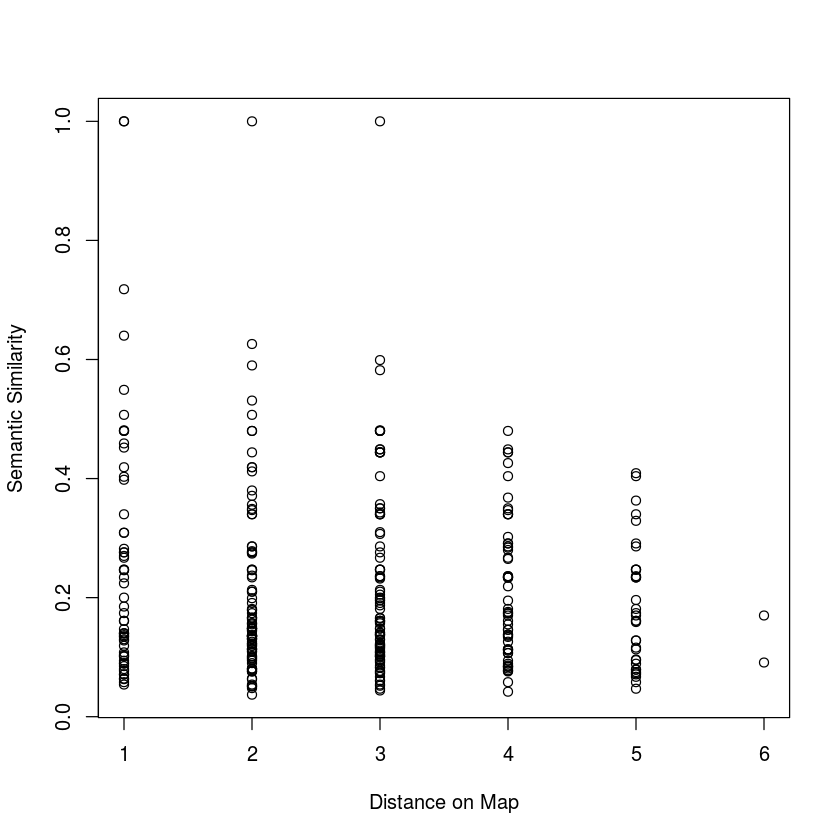

In [17]:
plot(distances, semSims, xlab="Distance on Map", ylab="Semantic Similarity")

In [18]:
cor(distances, semSims)

[1] -0.1040174